In [103]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [104]:
#x = np.random.rand(10000,2)
x=pd.read_csv('fkthat.csv', sep=',',header=None)
x = x.values

In [105]:
dx0 = 0.01
dx1 = 0.01

In [106]:
def minmax_scaling(array, columns, min_val=0, max_val=1):
    ary_new = array.astype(float)
    if len(ary_new.shape) == 1:
        ary_new = ary_new[:, np.newaxis]

    if isinstance(ary_new, pd.DataFrame):
        ary_newt = ary_new.loc
    elif isinstance(ary_new, np.ndarray):
        ary_newt = ary_new
    else:
        raise AttributeError('Input array must be a pandas'
                             'DataFrame or NumPy array')

    numerator = ary_newt[:, columns] - ary_newt[:, columns].min(axis=0)
    denominator = (ary_newt[:, columns].max(axis=0) -
                   ary_newt[:, columns].min(axis=0))
    ary_newt[:, columns] = numerator / denominator

    if not min_val == 0 and not max_val == 1:
        ary_newt[:, columns] = (ary_newt[:, columns] *
                                (max_val - min_val) + min_val)

    return ary_newt[:, columns]

In [107]:
y = minmax_scaling(x, columns=[0, 1])

In [108]:
i = np.floor(y[:,0]/dx0).astype('i')
j = np.floor(y[:,1]/dx1).astype('i')
gx = np.arange(0.5*dx0,1,dx0)
gy = np.arange(0.5*dx1,1,dx1)

In [109]:
from collections import defaultdict
counts = np.zeros((len(gx),len(gy)))
for n in range(len(i)):
    try:
        counts[i[n]-1][j[n]-1] += 1
    except:
        print(n)

<function matplotlib.pyplot.colorbar>

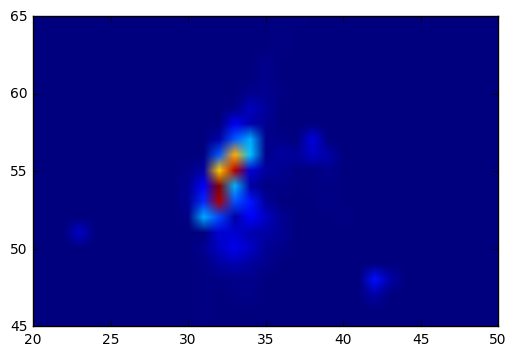

In [110]:
plt.imshow(counts)
plt.xlim(20,50)
plt.ylim(45,65)
plt.colorbar

In [111]:
latlongmap = {}
for num in range(len(x)):
    latlongmap[(x[num][0], x[num][1])] = (i[num],j[num])

In [112]:
class Pair:
    def __init__(self, lat, long):
        self.lat = lat
        self.long = long

    def __hash__(self):
        return hash((self.lat, self.long))

    def __eq__(self, other):
        return (self.lat, self.long) == (other.lat, other.long)

In [113]:
latlongmap = {}
for num in range(len(x)):
    latlongmap[Pair(x[num][0],x[num][1])] = Pair(i[num],j[num])

In [114]:
apr = pd.read_csv('./uber-raw-data-apr14.csv', sep=',',header=None)
apr = apr.values

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [115]:
apr = apr[1:]

In [116]:
len(apr)

564516

In [117]:
float(apr[0][2])

-73.9549

In [118]:
import math
def truncate(number, digits) -> float:
    stepper = pow(10.0, digits)
    return math.trunc(stepper * number) / stepper

In [119]:
f = open('april_parsed.txt','w');

count = 0;
for i in range(len(apr)):
   
    x = truncate(float(apr[i][1]),3)
    y = truncate(float(apr[i][2]),3)
    if(Pair(x,y) in latlongmap):
        grid =  latlongmap[Pair(x,y)]
        #print(grid.lat)
        #print(grid.long)
        count = count + 1;
        try:
            format(grid.lat)
            format(grid.long)
            f.write(apr[i][0]+','+str(apr[i][1])+','+str(apr[i][2])+','+apr[i][3]+','+ format(grid.lat) +','+ format(grid.long))
            f.write('\n')
        except:
            pass

f.close()
print(count)

410893
